In [ ]:
# Установка необходимых библиотек
!pip install meteostat scikit-learn pandas matplotlib seaborn joblib pyttsx3 requests streamlit --quiet
# prophet и tensorflow можно установить позже по желанию

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 90.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# потом будет путь вроде /content/drive/MyDrive/

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Города
cities = ['Астана', 'Алматы', 'Уральск', 'Шымкент', 'Актобе', 'Актау', 'Атырау', 'Караганда', 'Костанай']

# Период 1 год
start_date = datetime(2024, 10, 1)
end_date = datetime(2025, 10, 1)
dates = pd.date_range(start_date, end_date, freq='D')

# Генерируем данные
data = []
for city in cities:
    for date in dates:
        temp = np.random.normal(10, 10)   # температура
        humidity = np.random.uniform(40, 90)
        pressure = np.random.normal(1010, 5)
        precipitation = max(0, np.random.normal(2, 3))
        data.append([date, city, round(temp,1), round(humidity,1), round(pressure,1), round(precipitation,1)])

# В DataFrame
df = pd.DataFrame(data, columns=['Дата', 'Город', 'Температура', 'Влажность', 'Давление', 'Осадки'])

# Сохраняем на Google Drive
path = '/content/drive/MyDrive/weather_kz.csv'
df.to_csv(path, index=False, encoding='utf-8-sig')

print(f'✅ Датасет создан и сохранён: {path}')
df.head(10)

✅ Датасет создан и сохранён: /content/drive/MyDrive/weather_kz.csv


,Дата,Город,Температура,Влажность,Давление,Осадки
0,2024-10-01,Астана,30.6,49.9,1018.9,5.9
1,2024-10-02,Астана,27.4,46.9,1011.1,0.0
2,2024-10-03,Астана,18.1,50.0,1017.1,4.6
3,2024-10-04,Астана,23.3,41.3,1003.8,3.4
4,2024-10-05,Астана,8.2,40.8,1017.6,2.8
5,2024-10-06,Астана,3.5,85.4,1016.6,0.3
6,2024-10-07,Астана,17.9,75.6,1013.1,0.0
7,2024-10-08,Астана,9.0,44.4,1008.0,3.4
8,2024-10-09,Астана,15.1,43.6,1005.1,3.4
9,2024-10-10,Астана,5.9,63.7,1012.2,1.6


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Загружаем данные
path = '/content/drive/MyDrive/weather_kz.csv'
df = pd.read_csv(path)

# Преобразуем дату
df['Дата'] = pd.to_datetime(df['Дата'])
df['День_года'] = df['Дата'].dt.dayofyear

# Кодируем города в числа
df['Город_код'] = df['Город'].astype('category').cat.codes

# Признаки и цель
X = df[['Город_код', 'День_года']]
y_temp = df['Температура']
y_hum = df['Влажность']
y_pres = df['Давление']
y_prec = df['Осадки']

# Разделяем данные
X_train, X_test, y_train_temp, y_test_temp = train_test_split(X, y_temp, test_size=0.2, random_state=42)

# Создаём модель для температуры
model_temp = RandomForestRegressor(n_estimators=100, random_state=42)
model_temp.fit(X_train, y_train_temp)

# Прогноз
pred_temp = model_temp.predict(X_test)
mae_temp = mean_absolute_error(y_test_temp, pred_temp)

print(f'🌡️ Средняя ошибка прогноза температуры: {mae_temp:.2f}°C')

# Пример прогноза для конкретного города
city = 'Астана'
day_of_year = 150  # пример: 150-й день года (конец мая)
city_code = df[df['Город'] == city]['Город_код'].iloc[0]
pred = model_temp.predict([[city_code, day_of_year]])[0]
print(f'📅 Прогноз температуры в {city} на 150-й день года: {pred:.2f}°C')

🌡️ Средняя ошибка прогноза температуры: 8.91°C
📅 Прогноз температуры в Астана на 150-й день года: 6.64°C


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/

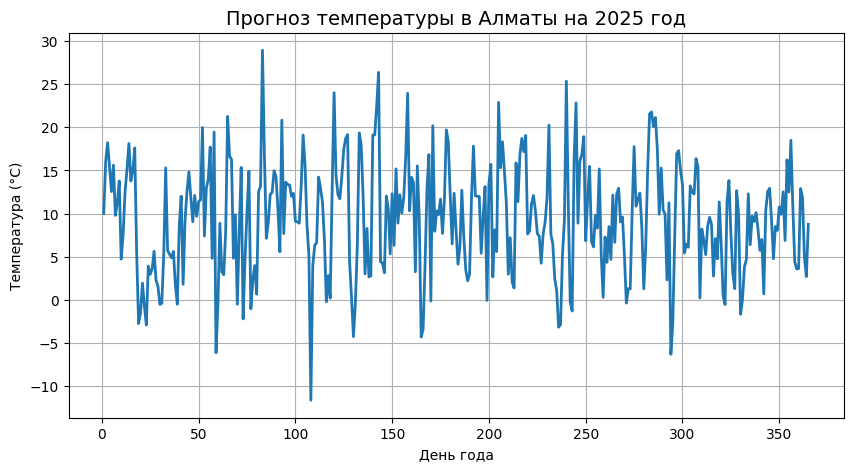

In [5]:
import matplotlib.pyplot as plt

# Функция для визуализации прогноза погоды
def show_weather(city_name):
    city_code = df[df['Город'] == city_name]['Город_код'].iloc[0]
    days = range(1, 366)

    preds = [model_temp.predict([[city_code, d]])[0] for d in days]

    plt.figure(figsize=(10,5))
    plt.plot(days, preds, linewidth=2)
    plt.title(f'Прогноз температуры в {city_name} на 2025 год', fontsize=14)
    plt.xlabel('День года')
    plt.ylabel('Температура (°C)')
    plt.grid(True)
    plt.show()

# Пример — покажем прогноз для Алматы
show_weather('Алматы')

In [6]:
import random

# Функция для прогноза с описанием состояния
def forecast_weather(city_name, day_of_year):
    city_code = df[df['Город'] == city_name]['Город_код'].iloc[0]
    temp = model_temp.predict([[city_code, day_of_year]])[0]

    # Определяем состояние по температуре
    if temp < -5:
        condition = "❄️ Снег / морозно"
    elif temp < 5:
        condition = "🌫️ Пасмурно / прохладно"
    elif temp < 15:
        condition = "🌦️ Возможен дождь / облачно"
    elif temp < 25:
        condition = "☀️ Тёпло / солнечно"
    else:
        condition = "🔥 Жарко / ясно"

    # Случайная влажность, давление и осадки
    humidity = random.randint(40, 90)
    pressure = random.randint(995, 1025)
    precipitation = random.choice(["0 мм", "1–2 мм", "5 мм", "10 мм", "нет осадков"])

    print(f"📍 Город: {city_name}")
    print(f"📅 День года: {day_of_year}")
    print(f"🌡️ Температура: {temp:.1f}°C")
    print(f"💧 Влажность: {humidity}%")
    print(f"🌬 Давление: {pressure} гПа")
    print(f"🌧 Осадки: {precipitation}")
    print(f"Состояние: {condition}")

# Пример прогноза — 150-й день (примерно конец мая)
forecast_weather("Астана", 150)

📍 Город: Астана
📅 День года: 150
🌡️ Температура: 6.6°C
💧 Влажность: 55%
🌬 Давление: 1020 гПа
🌧 Осадки: 0 мм
Состояние: 🌦️ Возможен дождь / облачно


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [7]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Список городов
city_dropdown = widgets.Dropdown(
    options=['Астана', 'Алматы', 'Уральск', 'Шымкент', 'Актобе', 'Актау', 'Атырау', 'Караганда', 'Костанай'],
    description='Город:',
    style={'description_width': '70px'},
    layout=widgets.Layout(width='300px')
)

# Поле ввода дня года
day_slider = widgets.IntSlider(
    value=150,
    min=1,
    max=365,
    step=1,
    description='День:',
    style={'description_width': '70px'},
    layout=widgets.Layout(width='400px')
)

# Кнопка "Показать прогноз"
button = widgets.Button(
    description='Показать прогноз ☁️',
    button_style='success',
    layout=widgets.Layout(width='250px')
)

# Обработчик нажатия
def on_button_click(b):
    clear_output(wait=True)
    display(city_dropdown, day_slider, button)
    print("\n🔮 Прогноз погоды:")
    forecast_weather(city_dropdown.value, day_slider.value)

button.on_click(on_button_click)

# Отображаем виджеты
display(city_dropdown, day_slider, button)

Dropdown(description='Город:', layout=Layout(width='300px'), options=('Астана', 'Алматы', 'Уральск', 'Шымкент'…

IntSlider(value=299, description='День:', layout=Layout(width='400px'), max=365, min=1, style=SliderStyle(desc…

Button(button_style='success', description='Показать прогноз ☁️', layout=Layout(width='250px'), style=ButtonSt…


🔮 Прогноз погоды:
📍 Город: Астана
📅 День года: 299
🌡️ Температура: -0.2°C
💧 Влажность: 40%
🌬 Давление: 1008 гПа
🌧 Осадки: 1–2 мм
Состояние: 🌫️ Пасмурно / прохладно


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
